In [34]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, when
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [35]:
spark = SparkSession.builder \
    .appName("Movie Ratings Analysis") \
    .getOrCreate()

In [36]:
ratings_df = spark.read.csv(r"C:\Users\moham\achref + mohamed\ratings.csv", header=True, inferSchema=True)
movies_df = spark.read.csv(r"C:\Users\moham\achref + mohamed\movies.csv", header=True, inferSchema=True)

ratings_df.printSchema()
ratings_df.show(5)
movies_df.printSchema()
movies_df.show(5)

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: string (nullable = true)

+------+-------+------+-------------------+
|userId|movieId|rating|          timestamp|
+------+-------+------+-------------------+
|     1|      2|   3.5|2005-04-02 23:53:47|
|     1|     29|   3.5|2005-04-02 23:31:16|
|     1|     32|   3.5|2005-04-02 23:33:39|
|     1|     47|   3.5|2005-04-02 23:32:07|
|     1|     50|   3.5|2005-04-02 23:29:40|
+------+-------+------+-------------------+
only showing top 5 rows

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|    

In [37]:
ratings_df.describe().show()

ratings_df = ratings_df.na.drop()

ratings_df.printSchema()

+-------+------------------+------------------+------------------+-------------------+
|summary|            userId|           movieId|            rating|          timestamp|
+-------+------------------+------------------+------------------+-------------------+
|  count|           5912912|           5912912|           5912912|            5912912|
|   mean|20182.830440229787| 9021.972482086661|3.5239466611375243|               NULL|
| stddev|11746.395552603097|19691.269297807492|1.0518745001600653|               NULL|
|    min|                 1|                 1|               0.5|1995-01-09 11:46:44|
|    max|             40722|            131258|               5.0|2015-03-31 06:03:17|
+-------+------------------+------------------+------------------+-------------------+

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: string (nullable = true)



In [38]:
from pyspark.sql.functions import explode, split

joined_df = ratings_df.join(movies_df, "movieId")

movies_df = movies_df.join(ratings_df, "movieId")

exploded_df = joined_df.withColumn("genre", explode(split(col("genres"), "\\|")))

average_rating_by_genre = exploded_df.groupBy("genre").avg("rating").orderBy("avg(rating)", ascending=False)
average_rating_by_genre.show()


+------------------+------------------+
|             genre|       avg(rating)|
+------------------+------------------+
|         Film-Noir| 3.959646979592476|
|               War|3.8092082158679017|
|       Documentary| 3.735163529058171|
|             Crime|3.6734156365931376|
|             Drama| 3.673230545064248|
|           Mystery|3.6594421066331178|
|              IMAX|   3.6513943812111|
|         Animation|3.6190126511672065|
|           Western|3.5686899427284273|
|           Musical| 3.557601479606736|
|           Romance| 3.539139768492282|
|          Thriller|3.5041603671792196|
|           Fantasy| 3.503038905673904|
|         Adventure|3.5020157867934136|
|            Action|3.4432225071645757|
|            Sci-Fi| 3.434580170424647|
|            Comedy|3.4253135746382006|
|          Children|3.4094251180979387|
|(no genres listed)|3.2928571428571427|
|            Horror|3.2664433410420353|
+------------------+------------------+



In [39]:
top_rated_movies = exploded_df.groupBy("title").avg("rating").orderBy("avg(rating)", ascending=False).limit(10)
top_rated_movies.show()

+--------------------+-----------+
|               title|avg(rating)|
+--------------------+-----------+
|Class Trip, The (...|        5.0|
|Step Up Love Stor...|        5.0|
| Living Proof (2008)|        5.0|
|Slingshot Hip Hop...|        5.0|
|Doctor and the De...|        5.0|
|Absolute Giganten...|        5.0|
|      Shottas (2002)|        5.0|
|       Hamoun (1990)|        5.0|
|Like Mike 2: Stre...|        5.0|
|Peppermint Soda (...|        5.0|
+--------------------+-----------+



In [40]:
ratings_df = ratings_df.withColumn("year", year(col("timestamp")))

average_rating_by_year = ratings_df.groupBy("year").avg("rating").orderBy("year")
average_rating_by_year.show()

+----+------------------+
|year|       avg(rating)|
+----+------------------+
|NULL|               4.0|
|1995|               4.0|
|1996|3.5522242123937637|
|1997|3.5740444336598274|
|1998| 3.491641472523564|
|1999|3.6170396549388015|
|2000|3.5691195098506014|
|2001|  3.53980778843737|
|2002| 3.489419719470966|
|2003| 3.456785458209794|
|2004|3.4250542000195745|
|2005|3.4260163115400055|
|2006|  3.47546094653137|
|2007|3.4557627973909955|
|2008| 3.554861352758969|
|2009|3.5275937148592864|
|2010| 3.527676542626966|
|2011|3.5721279155991494|
|2012|3.5795765398550725|
|2013| 3.646273326928547|
+----+------------------+
only showing top 20 rows



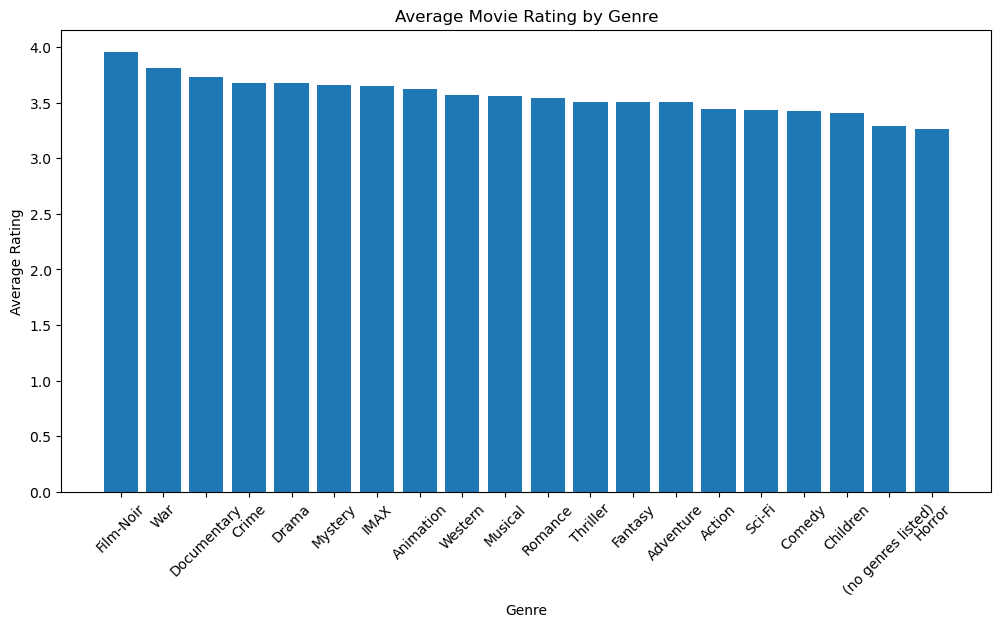

In [41]:
average_rating_pd = average_rating_by_genre.toPandas()

plt.figure(figsize=(12, 6))
plt.bar(average_rating_pd['genre'], average_rating_pd['avg(rating)'])
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.title('Average Movie Rating by Genre')
plt.xticks(rotation=45)
plt.show()


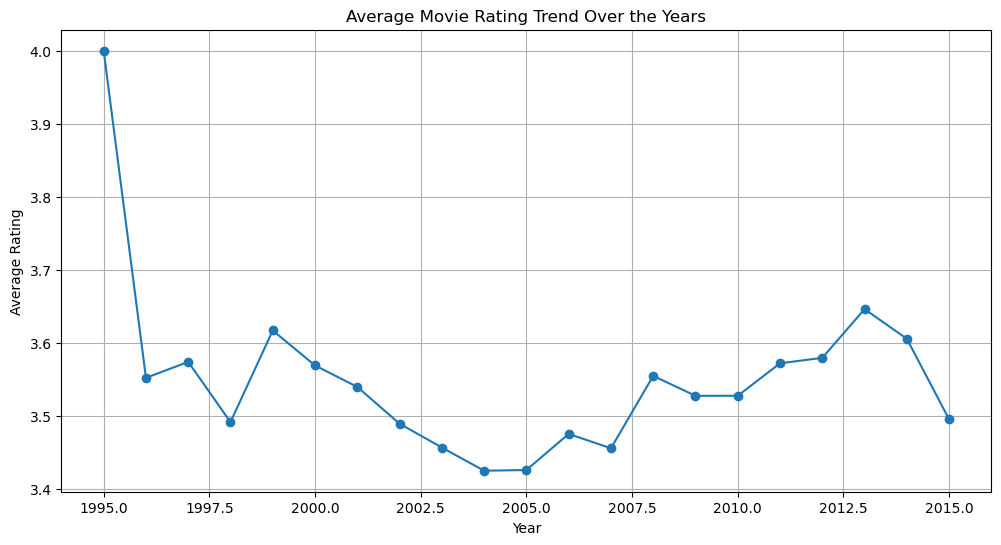

In [42]:
average_rating_by_year_pd = average_rating_by_year.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(average_rating_by_year_pd['year'], average_rating_by_year_pd['avg(rating)'], marker='o')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.title('Average Movie Rating Trend Over the Years')
plt.grid()
plt.show()

In [43]:
user_ratings = ratings_df.groupBy("userId").agg({"rating": "avg"}).withColumnRenamed("avg(rating)", "average_user_rating")
user_ratings.show()

+------+-------------------+
|userId|average_user_rating|
+------+-------------------+
|   148|          3.5859375|
|   463|             3.8875|
|   471|  3.502737226277372|
|   496|  4.130952380952381|
|   833|  3.617021276595745|
|  1088|  3.216666666666667|
|  1238|  3.731958762886598|
|  1342|               4.08|
|  1580|  2.261904761904762|
|  1591|               3.76|
|  1645| 3.5462962962962963|
|  1829|  4.133680555555555|
|  1959|  3.188053097345133|
|  2122| 2.9391304347826086|
|  2142| 3.9655172413793105|
|  2366|  4.071428571428571|
|  2659|  4.069306930693069|
|  2866| 3.4882978723404254|
|  3175|  4.386363636363637|
|   243|                3.5|
+------+-------------------+
only showing top 20 rows

